# Building a Decision Tree From Scratch in Python 


## 1. Motivation

My journey with tree-based methods began in 2020 when I first encountered decision trees in a machine learning course. Like many students, I started by implementing decision trees using established packages - first with rpart in R, and later with sklearn in Python. Through this experience, I came to appreciate the fundamental importance of decision trees as they serve as the foundation for more advanced tree-based algorithms. This recognition inspired me to build a decision tree algorithm from scratch. By implementing the algorithm myself rather than relying on existing packages, I aim to deepen my understanding of the underlying methodology while strengthening my Python programming skills.

## 2. CART(Classification And Regression Tree) for Decision Tree
Decision trees are non-parametric supervised learning techniques, meaning they do not assume any specific distribution for the underlying data. Instead, they learn patterns directly from labeled data, where the target variable is known. One of the most widely used decision tree methodologies is CART (Classification and Regression Tree), first introduced by Breiman et al. in 1984. As its name suggests, CART can be applied to both classification and regression tasks, forming the foundation for many modern decision tree algorithms.

In this project, I will first review the general structure of the CART algorithm and provide a step-by-step guide to implementing it from scratch using only the pandas and numpy libraries in Python. Lastly, I will test my implementation on Python’s built-in datasets — the breast cancer dataset (for classification) and the diabetes dataset (for regression). The performance of my implementation will be compared with the established decision tree model available in the scikit-learn library.
### 2.1 General Structure 
In the image below, I tried to show the general structure of a simple decision tree. In this example, the outcome variable Y is binary, indicating whether a patient has heart disease or not:

- Y = 1: Patient has heart disease.
- Y = 0: Patient does not have heart disease.

![A Simple Decision Tree](dt_general_structure.png)

Key Components of a Decision Tree:
- Root Node: The top node of the tree, representing the initial decision point. All data starts here and is split based on the most important feature.
- Internal Node: Also called decision nodes, these are the points where data is further splitted into subgroups based on certain conditions. Each internal node represents a decision or test on a feature.
- Leaf Node: The final node of the tree, containing the output or decision (e.g., whether the patient has heart disease or not). Leaf nodes do not split further.


### 2.2 Overview of the CART Algorithm Flow
In general, the CART algorithm builds a decision tree by recursively splitting the dataset into subsets based on feature values. The goal is to create pure subsets where the target variable is as homogeneous as possible. Below are the key steps in the CART algorithm.
1. Choose the Best Split: Search through all the predictors and possible split points (thresholds). Pick the predctor and split point that result in the best split, minimizing impurity (e.g., Gini index for classification or Mean Squared Error for regression). This feature and threshold combination become the root node.
2. Split the Data: Divides the data into two subsets based on the chosen feature and threshold:
    - One subset where the condition is true (e.g., feature value ≤ threshold).
    - Another subset where the condition is false (e.g., feature value > threshold).
3. Recursive binary splitting: Starting from the previously formed region. Repeat step 1 and 2, and stop once a stopping criterion is reached. 
4. Assign Outcomes to Leaf Nodes: Once the stopping criterion is reached and no further splits are possible, assign a final prediction to each leaf node:
    - For classification tasks, assign the majority class of the samples in the node.
    - For regression tasks, assign the mean target value of the samples in the node.

In [19]:
# Load packages 
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import graphviz
from graphviz import Source
import pygraphviz

## 3. Metrics to Decide a Good Split
The CART algorithm evaluates possible splits to identify the one that minimizes impurity or error. Different metrics are used depending on the task. 
### 3.1 Gini Impurity
Suppose the response variable $Y$ has $C$ different classes, and the tree has $R$ total regions/nodes. We want to first measure the purity of a single node.  

Let $p$ = proportion of cases in region/node $r$ that are of class $c$,  the node/region's Gini Impurity, or Gini Index, is calculated as:  

$$
G_r = \sum_{c=1}^{C} \left( p \cdot (1 - p) \right)
$$

The smaller $G$ is, the purer the region $r$ becomes. When $G = 0$, the region is perfectly pure, meaning all samples in the node belong to a single class.

To determine the "best" binary split, we compute the **weighted Gini** Impurity as follows:
$$
G_{\text{weighted}} = \sum_{r=1}^{R} \left( G_r \cdot \frac{\text{\# cases in region } r}{\text{total \# cases}} \right)
$$
The split with the lowest $G_{\text{weighted}}$ is considered the "best" split. This metric is primarily used in **classification tasks**.

In [2]:
# Define Helper Functions
# Split a dataset based on a feature and a given threshold
def split_data (feature_index, threshold, data):
    left, right = [], []
    for row in data:
        if row[feature_index] <= threshold:
            left.append(row)
        else:
            right.append(row)
    #left = np.array(left)
    #right = np.array(right)
    return left, right

# Gini Impurity 
# weighted gini impurity = (left group size / total samples)* Gini_left + (right group size / total samples)* Gini_right
def gini_impurity(groups, classes, class_index):
    '''
    Parameters:
        groups: A list of all subsets (left and right groups)
        classes: Target classes, e.g. 0 & 1, male and female
        class_index: Column index of class label in the data
    '''
    total_sample = sum(len(group) for group in groups) 
    weighted_gini = 0
    for group in groups:
        group_size = len(group)
        if group_size == 0:
            continue # skip empty groups
        
        gini = 0
        for class_label in classes:
            class_size = sum(1 for row in group if row[class_index] == class_label)
            p = class_size/group_size 
            gini += p**2
        group_gini = 1-gini
        weighted_gini += group_gini * (group_size/total_sample)

    return weighted_gini

### 3.2  Entropy
Entropy is another popular metric for **classification tasks**, measuring the impurity of a region. Similar to Gini Impurity, lower entropy indicates more homogeneity in a region. 
Entropy is calculated as: 
$$
Entropy_r = -\sum_{c=1}^{C} \left( p \cdot log_2(p) \right)
$$
where
- Entropy_r is the entropy of a region/node $r$.
- C is the total number of classes in the response vairable $Y$.
- $p$ is the proportion of cases in region/node $r$ that beglong to class $c$.
To determine the "best" binary split using entropy, we compute the **weighted entropy** as follows:
$$
Entropy_{\text{weighted}} = \sum_{r=1}^{R} \left( Entropy_r \cdot \frac{\text{\# cases in region } r}{\text{total \# cases}} \right)
$$

In [3]:
# Entropy
def entropy(groups, classes, class_index):
    total_sample = sum(len(group) for group in groups) 
    weighted_entropy = 0
    for group in groups:
        group_size = len(group)
        if group_size == 0:
            continue # skip empty groups
    
        entropy = 0
        for class_label in classes:
            class_size = sum(1 for row in group if row[class_index] == class_label)
            p = class_size/group_size
            if p > 0:
                entropy -= p * np.log2(p)
        weighted_entropy += entropy * (group_size/total_sample)
    
    return weighted_entropy

### 3.3 Mean Squared Error (MSE)
For **regression tasks**, we use the Mean Squared Error (MSE) as the metric to measure the impurity of a region. MSE quantifies the variance within a region by calculating the average squared difference between the actual values and the mean value of the region. It is defined as:
$$
MSE_r = \frac{1}{N_r} \sum_{i=1}^{N_r} \left( y_i - \bar{y_r} \right)^2
$$
where:
- $MSE_r$ is the Mean Squared Error for region/node $r$.
- $N_r$ is the number of cases in region $r$.
- $y_i$ represents the true target value of the $i$-th case in region $r$.
- $\bar{y_r}$ is the mean target value of all cases in region $r$.

The smaller $MSE_r$ is, the less variance there is in the region, indicating a better split. If $MSE_r = 0$, the region is perfectly pure.

To determine the "best" binary split using MSE, we compute the **weighted MSE** as follows:
$$
MSE_{\text{weighted}} = \sum_{r=1}^{R} \left( MSE_r \cdot \frac{\text{\# cases in region } r}{\text{total \# cases}} \right)
$$

In [4]:
# MSE for regression task
def mse(groups, target_index):
    total_sample = sum(len(group) for group in groups)
    weighted_mse = 0
    
    for group in groups:
        group_size = len(group)
        if group_size == 0:
            continue # skip empty groups

        group_value = [row[target_index] for row in group]
        group_mean = np.mean(group_value)
        group_mse = sum((x - group_mean) ** 2 for x in group_value) / group_size
        weighted_mse += group_mse * (group_size/total_sample)

    return weighted_mse

### 3.4 Finding the best split
After defining functions to compute the metrics for classification and regression tasks, we can create a new function to identify the best split. My find_best_split function incorporates four key elements:
1. The input dataset.
2. The index of the target variable column.
3. A task parameter that specifies whether the task is classification or regression.
4. The metric used to calculate impurity and evaluate splits (e.g., Gini, Entropy, or MSE).

This function iterates through all features and possible split thresholds, evaluates the impurity for each split, and selects the feature and threshold combination that minimizes the chosen metric. The result is the optimal split for the current dataset.

In [5]:
# Find the best split
def find_best_split(data, target_index, task = 'classification', criterion = 'gini'):
    '''
    Parameters:
        data: Input dataset where rows are samples and columns are features.
        target_index: The index of the column which is chosen to be the target variable.
        task: Classification or Regression. (default is classification)
        criterion: Gini, Entropy, or MSE (default criterion is gini index)
    
    Returns:
        best_feature_index: The index of the best feature of splitting.
        best_threshold: The threshold or values that gives the best split.
        best_score: The best (lowest) gini impurity score for the split.
    '''
    best_feature_index = None
    best_threshold = None
    best_score = float('inf')

    data = np.array(data)
    n_features = data.shape[1] # number of columns in the data

    # Extract unique class labels from the target column
    if task == 'classification':
        classes = np.unique(data[:, target_index])

    for feature_index in range(n_features):
        if feature_index == target_index:
            continue # skip the target column

        # Extract unique values for each feature to test as splitting thresholds:
        thresholds = np.unique(data[:, feature_index])
        for threshold in thresholds:
            # Split the dataset into left and right groups using the defined function
            left_group, right_group = split_data(feature_index, threshold, data)
            groups = [left_group, right_group]

            if len(left_group) == 0 or len(right_group) == 0:
                continue # skip empty groups 
            
            if task == 'classification':
                if criterion == 'gini':
                    score = gini_impurity(groups, classes, target_index)
                elif criterion == 'entropy':
                    score = entropy(groups, classes, target_index)
            else:
                score = mse(groups, target_index)

            # Update the best split if the current score is better (lower)
            if score < best_score:
                best_score = score
                best_feature_index = feature_index
                best_threshold = threshold
                
    return best_feature_index, best_threshold, best_score

## 4. Build a Tree
**Now that we've defined all the necessary helper functions, it's time to put everything together and build the decision tree🌳!**

The DecisionTree class is designed to handle both classification and regression tasks. As previouly introduced, a decision tree built using the CART algorithm relies on recursively splitting the dataset into smaller subsets. However, this process cannot be endless. To successfully construct a tree, we need to define stopping criteria (e.g., maximum tree depth, minimum number of samples, or reaching a pure region).

Once the stopping criteria are met, the algorithm must terminate the recursion and assign a prediction to the node, which becomes a leaf node. To achieve this, I created a leaf_node function first within the class. This function ensures that predictions are assigned to nodes where further splitting is not possible, either because the data cannot be split further or the stopping conditions have been reached. 

The fit function orchestrates the training process by invoking the recursive_splitting function, which builds the tree step-by-step. Once the tree is built, it is stored in the self.tree attribute.

The predict function is used to traverse the built tree and generate predictions for new input samples. Starting from the root node, it follows the feature-based split conditions until it reaches a leaf node, where the prediction is returned. This function allows the trained decision tree to be applied effectively to unseen data.

In [7]:
# Build a tree
class DecisionTree:
    def __init__(self, task = 'classification', criterion = 'gini', min_sample=2, max_depth=None):
        self.task = task 
        self.criterion = criterion
        self.min_sample = min_sample
        self.max_depth = max_depth
        self.tree = None

    def leaf_node(self, data, target_index):
        target_val = [row[target_index] for row in data]
        if self.task == 'classification':
             # Find the most frequent element (class label) in the list
            return max(set(target_val), key = target_val.count)
        else:
            return np.mean(target_val)
    
    def recursive_splitting(self, data, target_index, depth = 0):
        # Define a stopping criteria 
        if depth >= self.max_depth or len(data)< self.min_sample:
            return self.leaf_node(data, target_index)

        # Use the previously defined function to find the best split
        best_feature_index, best_threshold, best_score = find_best_split(data, target_index)
        if best_feature_index is None:
            return self.leaf_node(data, target_index)

        # Use the previously defined function to split the data
        left, right = split_data (best_feature_index, best_threshold, data)
        if not left or not right: # empty groups
            return self.leaf_node(data, target_index)

        # Initiate the recursive process to build the right and left trees respectively 
        left_tree = self.recursive_splitting(left, target_index, depth + 1)
        right_tree = self.recursive_splitting(right, target_index, depth + 1)

        return {
            'feature': best_feature_index,
            'threshold': best_threshold,
            'left': left_tree,
            'right': right_tree
        }
    
    def fit(self, data, target_index):
        self.tree = self.recursive_splitting(data, target_index)
    
    def predict(self, row):
        '''
        While not a leaf, evaluate the feature against the threshold 
        and update the node either to the left or right subtree.
        '''
        node = self.tree # initiate a root node
        
        # Check whether the node is a terminal node. Terminal nodes will be stored in as dictionaries.
        # In contrast, if the node is a leaf node, it will not be a dictionary but a single value like a class label
        # for classification or a numerical value a numeric prediction for regression. In that case, the loop stops.  
        while isinstance(node, dict):  
            if row[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node

## 5. Testing the Algorithm

### 5.1 Testing case: Predicting Breast Cancer
To evaluate the algorithm's performance for classification tasks, I tested it using the Breast Cancer dataset from the sklearn library. The target variable in this dataset is binary, with two classes: 'malignant' and 'benign'. The goal of this test case is to predict whether a tumor is malignant or benign.

I first applied the custom decision tree algorithm to perform the classification task. Then, I compared its performance to the sklearn DecisionTreeClassifier. Both algorithms were tested using the same training and testing datasets, and the classification was performed using the Gini impurity criterion.

The results show that our custom algorithm achieved an accuracy of 92.98%, which is slightly lower than the 95% accuracy achieved by the sklearn implementation. This indicates that our custom algorithm can handle classification tasks effectively, but there is still room for improvement and optimization.

In [16]:
# Test case: Predicting Breast Cancer
# Load data
breast_cancer = load_breast_cancer()
# print (breast_cancer.feature_names)
# print (breast_cancer.target_names)
data = pd.DataFrame(data=breast_cancer.data, columns=breast_cancer.feature_names)
data['target'] = breast_cancer.target
# Split data into test and train
X = data.iloc[:, :-1]
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Testing the algorithm using the customed alogrithm
train_data = np.hstack((X_train.values, y_train.values.reshape(-1, 1)))  # Merge features and target
target_index = train_data.shape[1] - 1  
tree = DecisionTree(max_depth=5, min_sample=10) 
tree.fit(train_data, target_index)
print(tree.tree)
tree_structure = tree.tree

# Predict for the test set
predictions = [tree.predict(row) for row in X_test.values]

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

{'feature': 7, 'threshold': 0.05074, 'left': {'feature': 20, 'threshold': 16.77, 'left': {'feature': 10, 'threshold': 0.6061, 'left': {'feature': 24, 'threshold': 0.1768, 'left': {'feature': 14, 'threshold': 0.00328, 'left': 1.0, 'right': 1.0}, 'right': 0.0}, 'right': 0.0}, 'right': {'feature': 1, 'threshold': 15.7, 'left': 1.0, 'right': {'feature': 17, 'threshold': 0.009921, 'left': {'feature': 0, 'threshold': 13.43, 'left': 0.0, 'right': 0.0}, 'right': 1.0}}}, 'right': {'feature': 27, 'threshold': 0.1465, 'left': {'feature': 22, 'threshold': 114.3, 'left': {'feature': 1, 'threshold': 20.76, 'left': {'feature': 0, 'threshold': 9.268, 'left': 1.0, 'right': 1.0}, 'right': 0.0}, 'right': {'feature': 0, 'threshold': 14.25, 'left': 0.0, 'right': {'feature': 0, 'threshold': 16.11, 'left': 0.0, 'right': 0.0}}}, 'right': {'feature': 16, 'threshold': 0.1278, 'left': {'feature': 0, 'threshold': 11.08, 'left': 0.0, 'right': {'feature': 0, 'threshold': 11.42, 'left': 0.0, 'right': 0.0}}, 'right':

In [17]:
# Build the decision tree using the sklearn package
decision_tree_classifier = DecisionTreeClassifier(criterion='gini', random_state=42)
decision_tree_classifier.fit(X_train, y_train)
predictions = decision_tree_classifier.predict(X_test)
print(f"Model's Accuracy: {accuracy_score(y_test, predictions):.2f}")

Model's Accuracy: 0.95


##### 5.1.1 Decision Tree Visualization
The plot_tree function from the sklearn library is a commonly used tool when we want to visualize decision trees. However, to visualize the custom decision tree and better understand its structure and performance, I created a function that converts a tree dictionary into a DOT format file. This approach allows for a clear visualization of the tree and was inspired by a [blog post](https://blog.csdn.net/weixin_40722661/article/details/101631344). 

In [17]:
# Decision Tree Visulization (custom)
def write_dot_file(tree, filepath, attrs=None, classes=None, depth=0, node_id=0):
    '''
    Convert a tree dictionary into a DOT file format.
    
    Parameters:
        tree: The tree structure as a nested dictionary.
        filepath: Path to save the DOT file.
        attrs: Feature names (optional).
        classes: Class names (optional).
        depth: Current depth (used internally for recursive node indexing).
        node_id: Current node ID (used internally for recursive node indexing).
    
    Returns:
        The next available node_id for indexing.
    '''
    def node_label(node):
        if isinstance(node, dict): # If the node is a dictionary, it is a terminal/decision node.
            # if attrs:
            #     feature = attrs[node['feature']]
            # else:
            #     feature = f"Feature {node['feature']}"
            feature = attrs[node['feature']] if attrs else f"Feature {node['feature']}"
            return f"{feature} <= {node['threshold']}"
        else:  # Leaf node
            return f"Class: {classes[int(node)] if classes else node}" # If classes is not provided, use the value of node directly as the class label

    with open(filepath, "w") as dot_file:
        dot_file.write("digraph Tree {\n")
        
        def recurse(node, parent_id=None):
            nonlocal node_id
            current_id = node_id
            node_id += 1
            
            # Writes a line to the opened DOT file to record the current node
            dot_file.write(f'    {current_id} [label="{node_label(node)}"];\n')
            
            # parent_id ensures the hierarchical structure. Each node has a parent node except the root node.
            if parent_id is not None:
                dot_file.write(f'    {parent_id} -> {current_id};\n')
            
            # Recurse for left and right children if node is a terminal/decision node
            if isinstance(node, dict):
                recurse(node['left'], current_id)
                recurse(node['right'], current_id)
        
        recurse(tree)
        dot_file.write("}")

# Feature and class names
feature_names = list(X_train.columns)  # Column names from the dataset
class_names = ["Malignant", "Benign"]  # Target class labels

# Save the tree as a DOT file
write_dot_file(
    tree=tree_structure,
    filepath="decision_tree_update.dot",
    attrs=feature_names,
    classes=class_names
)
Source.from_file("decision_tree_update.dot").view()

'decision_tree_update.dot.pdf'

Below is the visualization of the decision tree generated using the sklearn package, created with the plot_tree function.

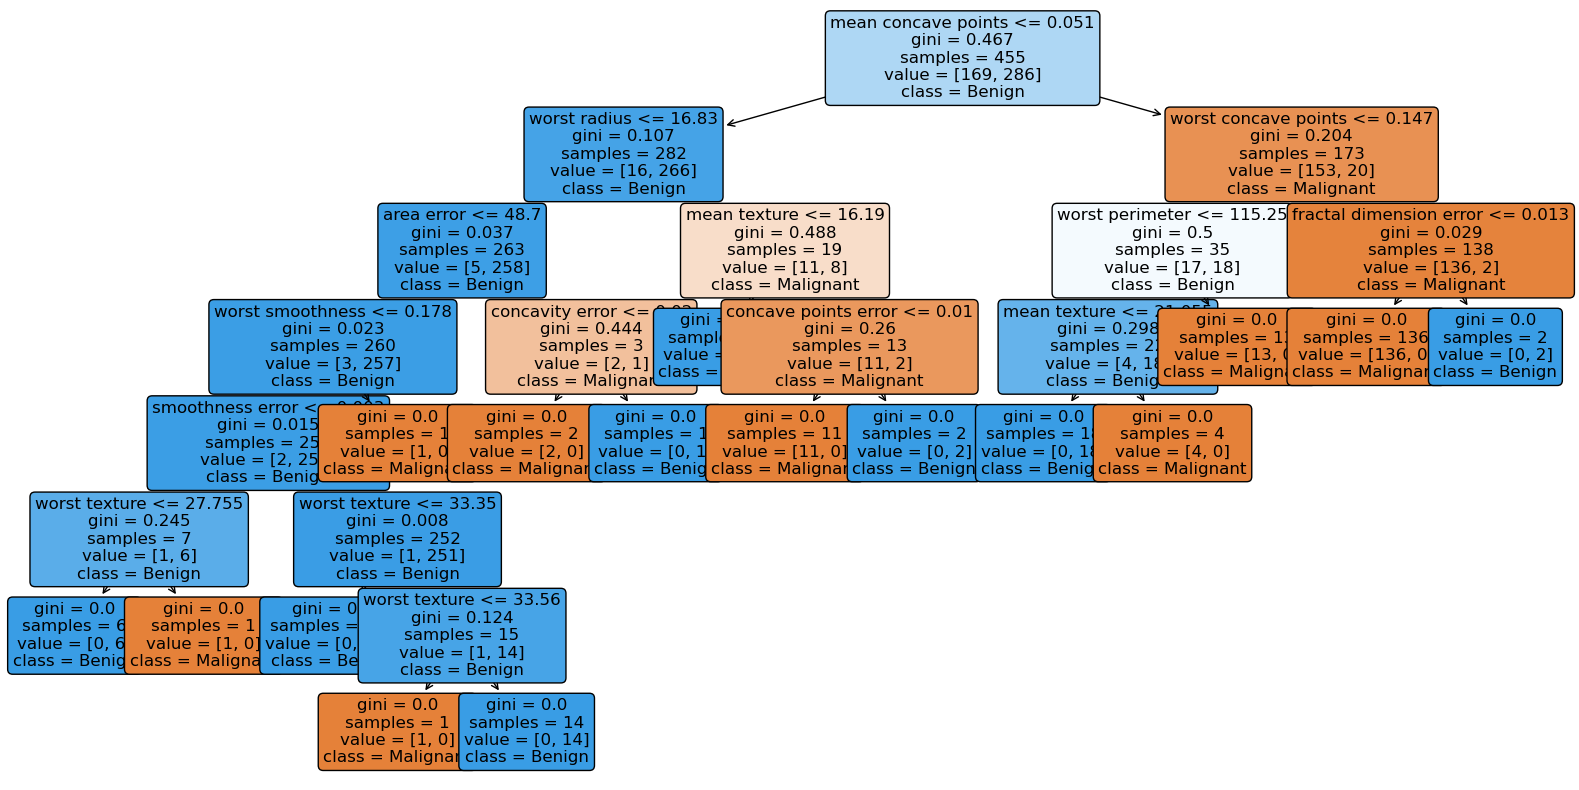

<Figure size 640x480 with 0 Axes>

In [18]:
# Visualize the tree using plot_tree
plt.figure(figsize=(20, 10))
plot_tree(
    decision_tree_classifier,
    feature_names=X.columns,  # Use feature names from the dataset
    class_names=['Malignant', 'Benign'],  # Use target class names
    filled=True,  # Color the nodes based on the class
    rounded=True,  # Rounded edges for better visualization
    fontsize=12  # Font size for text
)
plt.show()

### 5.2 Testing case: Predicting Diabetes

To evaluate the algorithm's performance for **regression tasks**, I tested it using the Diabetes dataset from the sklearn library. This dataset contains 10 predictors and a target variable representing a quantitative measure of disease progression. [See the full dataset description](https://scikit-learn.org/1.5/datasets/toy_dataset.html). 

Again, the goal of this test is to compare the custom decision tree regressor against sklearn's DecisionTreeRegressor using the same training and testing datasets. The performance is assessed using common regression metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), and R² Score.

Both models achieve the same R² score (0.33) and show similar results for MSE and MAE, indicating a moderate fit to the data. While neither model fully captures the variance in the dataset, the results validate that our custom algorithm performs effectively and is competitive with sklearn's implementation.

In [20]:
diabetes = load_diabetes()
# print(pd.isna(diabetes)) # check NA values
data_reg = pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)
data_reg['target'] = diabetes.target
# Split data into test and train
X = data_reg.iloc[:, :-1]
y = data_reg['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Predict using my customized algorithm
# Combine X_train and y_train for custom algorithms
train_data = np.hstack((X_train.values, y_train.values.reshape(-1, 1))) 
target_index = train_data.shape[1] - 1  
reg_tree = DecisionTree(task = 'regression', criterion= 'mse', max_depth=5, min_sample=10) 
reg_tree.fit(train_data, target_index)
print(reg_tree.tree)

# Predict
tree_structure = reg_tree.tree
reg_predictions = [reg_tree.predict(row) for row in X_test.values]

# Evaluate custom Decision Tree for regression
custom_mse = mean_squared_error(y_test, reg_predictions)
custom_mae = mean_absolute_error(y_test, reg_predictions)
custom_r2 = r2_score(y_test, reg_predictions)

print("Custom Decision Tree Regressor Performance:")
print(f"Mean Squared Error (MSE): {custom_mse:.2f}")
print(f"Mean Absolute Error (MAE): {custom_mae:.2f}")
print(f"R² Score: {custom_r2:.2f}")

{'feature': 2, 'threshold': -0.010517202431330305, 'left': {'feature': 2, 'threshold': -0.06548561819925106, 'left': {'feature': 3, 'threshold': -0.0228846771720037, 'left': {'feature': 4, 'threshold': -0.04972730985725048, 'left': 89.71428571428571, 'right': {'feature': 5, 'threshold': -0.043275771306016404, 'left': 59.0, 'right': 83.44444444444444}}, 'right': 93.66666666666667}, 'right': {'feature': 6, 'threshold': -0.06180903467245962, 'left': 105.5, 'right': {'feature': 4, 'threshold': -0.07587041416307178, 'left': {'feature': 0, 'threshold': -0.08543040090123728, 'left': 71.0, 'right': 116.33333333333333}, 'right': {'feature': 9, 'threshold': -0.05492508739331389, 'left': 96.71428571428571, 'right': 120.79166666666667}}}}, 'right': {'feature': 7, 'threshold': -0.03395821474270679, 'left': {'feature': 8, 'threshold': -0.018113692315690322, 'left': {'feature': 5, 'threshold': -0.048286146694648965, 'left': 141.66666666666666, 'right': {'feature': 9, 'threshold': -0.00936191133013487

In [ ]:
# Prediction using Sklearn
sklearn_tree = DecisionTreeRegressor(criterion='squared_error', max_depth=3, min_samples_split=2)
sklearn_tree.fit(X_train, y_train)
sklearn_predictions = sklearn_tree.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, sklearn_predictions)
mae = mean_absolute_error(y_test, sklearn_predictions)
r2 = r2_score(y_test, sklearn_predictions)

print("Scikit-learn Decision Tree Regressor Performance:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(sklearn_tree, feature_names=X_train.columns, filled=True)
plt.title("Scikit-learn Decision Tree Regressor")
plt.show()

## 6. Conclusion
Now we have seen how to build a basic decision tree from scratch using only pandas and numpy. Despite its simplicity, the custom algorithm performs reasonably well on both classification and regression tasks, as demonstrated with the breast cancer and diabetes datasets.

This project highlights the core mechanics of the CART algorithm, including recursive splitting, calculating metrics like Gini impurity and MSE, and defining stopping criteria to avoid overfitting. By comparing the custom decision tree with sklearn's implementation, we observed that the custom model achieves comparable results, validating the robustness of the algorithm.

Building this decision tree from scratch has been both a challenging and rewarding journey. I enjoyed the process of deepening my understanding of the underlying algorithm. There are certainly opportunities for further enhancements, such as adding support for pruning to reduce overfitting. My next step is probably to sracth other algorithm based on the decision tree framework, such as the Random Forest and Gradient Boosted Trees.